In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
pd.set_option("display.max.columns", None)
df = pd.read_csv('organizations.csv')
df.head()

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,legal_name,roles,domain,homepage_url,country_code,state_code,region,city,address,postal_code,status,short_description,category_list,category_groups_list,num_funding_rounds,total_funding_usd,total_funding,total_funding_currency_code,founded_on,last_funding_on,closed_on,employee_count,email,phone,facebook_url,linkedin_url,twitter_url,logo_url,alias1,alias2,alias3,primary_role,num_exits
0,e1393508-30ea-8a36-3f96-dd3226033abd,Wetpaint,organization,wetpaint,https://www.crunchbase.com/organization/wetpaint,223046.0,2007-05-25 13:51:27,2022-03-07 05:47:35,NaN,company,wetpaint.com,http://www.wetpaint.com/,USA,NY,New York,New York,902 Broadway 11th Floor New,10010,acquired,Wetpaint offers an online social publishing pl...,"Publishing,Social Media,Social Media Management","Content and Publishing,Internet Services,Media...",3.0,3.975000e+07,3.975000e+07,USD,2005-06-01,2008-05-19,NaN,51-100,info@wetpaint.com,206-859-6300,https://www.facebook.com/Wetpaint,NaN,https://twitter.com/wetpainttv,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN
1,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,zoho,https://www.crunchbase.com/organization/zoho,94008.0,2007-05-26 02:30:28,2022-07-19 01:20:31,Zoho Corporation Pvt. Ltd.,"investor,company",zoho.com,https://www.zoho.com,USA,CA,California,Pleasanton,NaN,NaN,operating,"Zoho offers a suite of business, collaboration...","Cloud Computing,Collaboration,CRM,Developer To...","Administrative Services,Information Technology...",NaN,NaN,NaN,NaN,1996-03-17,NaN,NaN,10000+,sales@zohocorp.com,044 - 67447070,http://www.facebook.com/zoho,https://www.linkedin.com/company/zoho,http://twitter.com/zoho,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,1.0
2,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,Digg,organization,digg,https://www.crunchbase.com/organization/digg,27046.0,2007-05-26 03:03:23,2018-12-10 10:09:14,"Digg Holdings, LLC",company,digg.com,http://www.digg.com,USA,NY,New York,New York,NaN,NaN,acquired,Digg Inc. operates a website that enables its ...,"Internet,Social Media,Social Network","Internet Services,Media and Entertainment",6.0,4.900000e+07,4.900000e+07,USD,2004-10-11,2016-09-13,NaN,51-100,feedback@digg.com,877-342-7222,http://www.facebook.com/digg,http://www.linkedin.com/company/digg,http://twitter.com/digg,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,company,NaN
3,f4d5ab44-058b-298b-ea81-380e6e9a8eec,Omidyar Network,organization,omidyar-network,https://www.crunchbase.com/organization/omidya...,237257.0,2007-05-26 03:21:34,2022-07-19 01:45:23,NaN,"investor,company",omidyar.com,http://www.omidyar.com,USA,CA,California,Redwood City,1991 Broadway Suite 200,94063,operating,Omidyar Network is an investment firm.,"Enterprise Software,Financial Services,Venture...","Financial Services,Lending and Investments,Sof...",NaN,NaN,NaN,NaN,2004-01-01,NaN,NaN,101-250,info@omidyar.com,650.482.2500,http://www.facebook.com/OmidyarNetwork,http://www.linkedin.com/company/22806,http://twitter.com/OmidyarNetwork,https://res.cloudinary.com/crunchbase-producti...,NaN,NaN,NaN,investor,51.0
4,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,facebook,https://www.crunchbase.com/organization/facebook,28.0,2007-05-26 04:22:15,2022-07-15 10:36:26,"Meta Platforms, Inc.","investor,company",meta.com,https://meta.com,USA,CA,California,Menlo Park,1 Hacker Way,94025,ipo,Meta is a social technology company that enabl...,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",16.0,1.612282e+10,1.612282e+10,USD,2004-02-04,2014-10-20,NaN,10000+,NaN,NaN,https://www.facebook.com/Meta,https://www.linkedin.com/company/meta/,https://twitter.com/Meta,https://res.cloudinary.com/crunchbase-producti...,Facebook,"Facebook, Inc.",NaN,company,NaN


In [3]:
df.shape

(2160249, 41)

### Removing Companies with vital financial information missing

In [4]:
df = df.dropna(axis=0, subset=['num_funding_rounds','total_funding_usd'])
df = df.drop(df.loc[df['total_funding_usd']==0].index)

In [5]:
df.shape

(182748, 41)

### Removing Companies Founded Before 2012

Creating a variable that only includes the Year value from the 'founded_on' variable:

In [6]:
df['founded_on'] = pd.to_datetime(df['founded_on'], errors = 'coerce')
df['founded_on'] = pd.DatetimeIndex(df['founded_on']).year

In [7]:
df['last_funding_on'] = pd.to_datetime(df['last_funding_on'], errors = 'coerce')
df['last_funding_on'] = pd.DatetimeIndex(df['last_funding_on']).year

In [8]:
df['closed_on'] = pd.to_datetime(df['closed_on'], errors = 'coerce')
df['closed_on'] = pd.DatetimeIndex(df['closed_on']).year

Excluding companies not classified as start-ups:

In [9]:
df = df.drop(df.loc[df['founded_on']<2012.0].index)
df = df.drop(df.loc[df['last_funding_on']<2000.0].index)

In [10]:
df.shape

(115603, 41)

### Dropping Potential Ghost Firms

In [11]:
df = df.dropna(axis=0, subset=['name','founded_on','domain'])
df.shape

(107269, 41)

### Dropping Companies Without Industry Specifications

In [12]:
df = df.dropna(axis=0, subset=['category_groups_list'])
df.shape

(104877, 41)

### Transforming Employment Count to Separate Companies Based on Size 

As per....
* Small-Sized Enterprise: 0-50 Employees
* Medium-Sized Enterprise: 50-250 Employees
* Large-Sized Enterprise: 250+ Employees

In [13]:
df = df.drop(df.loc[df['employee_count']=='unknown'].index)
df.shape

(100709, 41)

In [14]:
df['employee_count'] = df['employee_count'].map({'1-10': 'SSE', '11-50': 'SSE',
                                                 '51-100': 'MSE', '101-250': 'MSE',
                                                 '251-500': 'LSE', '501-1000': 'LSE', '1001-5000': 'LSE',
                                                 '5001-10000': 'LSE', '10000+': 'LSE'})

Mapping the variable to the individual categories created variables with near-zero variance and ran the risk of creating granularity.
Transforming the variable to the 3 categories overcomes this issue.

### Checking for Duplicates

In [15]:
df.duplicated().any()

False

### Transforming Total Funding (USD) Into An Integer

In [16]:
df['total_funding_usd']=df['total_funding_usd'].apply(lambda x: '%.0f' % x)

### Generating Variables 

In [17]:
company_age = 2022 - df['founded_on']
df['age'] = company_age

In [18]:
df['age'].describe()

count    100709.000000
mean          6.093179
std           2.578281
min           0.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: age, dtype: float64

In [19]:
yrs_since_last_funding = 2022 - df['last_funding_on']
df['yrs_since_last_funding'] = yrs_since_last_funding

In [20]:
df['yrs_since_last_funding'].describe()

count    100709.000000
mean          3.337666
std           2.659835
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max          22.000000
Name: yrs_since_last_funding, dtype: float64

In [21]:
df['last_funding_on'].describe()

count    100709.000000
mean       2018.662334
std           2.659835
min        2000.000000
25%        2017.000000
50%        2019.000000
75%        2021.000000
max        2022.000000
Name: last_funding_on, dtype: float64

In [22]:
last_funding_lag = df['last_funding_on'] - df['founded_on']
df['last_funding_lag'] = last_funding_lag

In [23]:
df['last_funding_lag'].describe()

count    100709.000000
mean          2.755513
std           2.287074
min         -19.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          10.000000
Name: last_funding_lag, dtype: float64

### Merging Socials

In [24]:
df['facebook_url'] = df['facebook_url'].fillna(0)
df['facebook_url'] = np.where((df['facebook_url']!=0), 1, df['facebook_url'])
df['linkedin_url'] = df['linkedin_url'].fillna(0)
df['linkedin_url'] = np.where((df['linkedin_url']!=0), 2, df['facebook_url'])
df['twitter_url'] = df['twitter_url'].fillna(0)
df['twitter_url'] = np.where((df['twitter_url']!=0), 4, df['facebook_url'])

df['facebook_url'] = pd.to_numeric(df['facebook_url'])
df['linkedin_url'] = pd.to_numeric(df['linkedin_url'])
df['twitter_url'] = pd.to_numeric(df['twitter_url'])

df['social'] = df['facebook_url'] + df['linkedin_url'] + df['twitter_url']
df = df.drop(['facebook_url', 'twitter_url', 'linkedin_url'], axis=1)

In [25]:
df['social'] = df['social'].map({0: 'None', 1: 'Weak', 2: 'Weak',
                                4: 'Weak', 3: 'Medium',
                                5: 'Medium',
                                6: 'Medium', 7: 'Strong' })

Mapping the variable to None, F, L, T, F+T, F+L, T+L, F+T+L created variables with near-zero variance and ran the risk of creating granularity. Transforming the variable to the 4 categories overcomes this issue.

### Generating Sector Variable

In [26]:
#Parsing the Industry Variable (category_groups_list)
df2 = df['category_groups_list'].str.split(',', n=1, expand = True)
sector = df2.drop([1], axis=1)
df['sector'] = sector

In [27]:
sector.value_counts()

Commerce and Shopping               10083
Financial Services                   9234
Artificial Intelligence              8041
Apps                                 7827
Health Care                          5835
Biotechnology                        5317
Information Technology               5079
Consumer Electronics                 3926
Administrative Services              3880
Data and Analytics                   3810
Education                            3363
Community and Lifestyle              3302
Advertising                          3159
Hardware                             3143
Food and Beverage                    2489
Internet Services                    2273
Energy                               2105
Agriculture and Farming              2097
Clothing and Apparel                 1847
Content and Publishing               1516
Gaming                               1504
Other                                1280
Software                             1248
Media and Entertainment           

In [28]:
#Mapping the Industry to the corresponding sector, as per the S&P 500
df['sector'] = df['sector'].map({"Commerce and Shopping": "Consumer Staples",
                                 "Financial Services": "Financial Services",
                                 "Artificial Intelligence": "Technology",
                                 "Apps": "Technology",
                                 "Health Care": "Health Care",
                                 "Biotechnology": "Technology",
                                 "Information Technology": "Technology",
                                 "Consumer Electronics": "Consumer Directory",
                                 "Administrative Services": "Industrials",
                                 "Data and Analytics": "Technology",
                                 "Education": "Industrials",
                                 "Community and Lifestyle": "Consumer Directory",
                                 "Hardware": "Industrials",
                                 "Advertising": "Communications Services",
                                 "Food and Beverage": "Consumer Staples",
                                 "Internet Services": "Technology",
                                 "Energy": "Industrials",
                                 "Agriculture and Farming": "Industrials",
                                 "Clothing and Apparel": "Consumer Directory",
                                 "Gaming": "Consumer Directory",
                                 "Content and Publishing": "Communications Services",
                                 "Other": "Industrials",
                                 "Software": "Technology",
                                 "Manufacturing": "Industrials",
                                 "Media and Entertainment": "Consumer Directory",
                                 "Consumer Goods": "Consumer Staples",
                                 "Real Estate": "Real Estate",
                                 "Transportation": "Consumer Staples",
                                 "Design": "Industrials",
                                 "Events": "Consumer Directory",
                                 "Professional Services": "Industrials",
                                 "Mobile": "Technology",
                                 "Travel and Tourism": "Consumer Directory",
                                 "Government and Military": "Industrials",
                                 "Science and Engineering": "Technology",
                                 "Sales and Marketing": "Financial Services",
                                 "Natural Resources": "Industrials",
                                 "Sports": "Consumer Directory",
                                 "Sustainability": "Industrials",
                                 "Privacy and Security": "Industrials",
                                 "Messaging and Telecommunications": "Communications Services",
                                 "Navigation and Mapping": "Technology",
                                 "Payments": "Financial Services",
                                 "Platforms": "Technology"})

In [29]:
df.sector.value_counts()

Technology                 34232
Industrials                18690
Consumer Staples           14282
Consumer Directory         12741
Financial Services          9458
Health Care                 5835
Communications Services     4696
Real Estate                  775
Name: sector, dtype: int64

In [30]:
df['sector'].shape

(100709,)

### Transforming countrycode into Grouped Regions (Continent)

In [31]:
df = df.dropna(axis=0, subset=['country_code'])
df.shape

(99434, 43)

In [32]:
pd.set_option("display.max.rows", None)

df.country_code.value_counts()

USA    40379
CHN     9331
GBR     7494
IND     4410
CAN     3605
FRA     2495
DEU     2178
ESP     1959
JPN     1755
AUS     1600
ISR     1585
SGP     1470
BRA     1392
CHE     1263
NLD     1142
SWE     1118
ITA     1080
RUS      681
KOR      639
IRL      605
FIN      595
TUR      556
MEX      547
DNK      528
ARE      506
POL      505
BEL      472
HKG      452
CHL      433
IDN      413
NOR      392
EGY      386
NGA      377
EST      346
MYS      315
PRT      288
ARG      286
AUT      285
ZAF      278
COL      276
HUN      238
KEN      233
CZE      229
NZL      203
SAU      196
BGR      174
TWN      168
PHL      165
PAK      163
VNM      153
ROM      151
UKR      151
LTU      146
ISL      135
THA      131
LVA      130
BGD      117
GRC      115
CYP      102
LUX      100
PER       92
HRV       86
JOR       78
GHA       74
SVK       68
SVN       65
LBN       62
LKA       58
UGA       57
MMR       49
SRB       47
MLT       40
CYM       40
TUN       39
MAR       38
PRI       36
URY       35

In [33]:
region = {
    'USA': 'North America',
    'DEU': 'Europe',
    'CHN': 'Asia',
    'AUS': 'Oceania',
    'NLD': 'Europe',
    'GBR': 'Europe',
    'IND': 'Asia',
    'ARG': 'South America',
    'SGP': 'Asia',
    'CAN': 'North America',
    'VNM': 'South America',
    'ARE': 'Asia',
    'BGR': 'Europe',
    'ESP': 'Europe',
    'FRA': 'Europe',
    'NOR': 'Europe',
    'ISR': 'Asia',
    'IDN': 'Asia',
    'FIN': 'Europe',
    'BEL': 'Europe',
    'PAK': 'Asia',
    'ITA': 'Europe',
    'BRA': 'South America',
    'SWE': 'Europe',
    'CHL': 'South America',
    'CHE': 'Europe',
    'PRT': 'Europe',
    'VEN': 'South America',
    'LTU': 'Europe',
    'AUT': 'Europe', 
    'URY': 'South America',
    'HKG': 'Asia',
    'GRC': 'Europe',
    'IRL': 'Europe',
    'MEX': 'Central America',
    'HRV': 'Europe',
    'KOR': 'Asia',
    'ZAF': 'Africa',
    'TUR': 'Asia',
    'CZE': 'Europe',
    'ISL': 'Europe',
    'MYS': 'Asia',
    'LVA': 'Europe',
    'POL': 'Europe',
    'LBN': 'Asia',
    'UKR': 'Europe',
    'RUS': 'Europe',
    'COL': 'South America',
    'EGY': 'Africa',
    'PHL': 'Asia',
    'GTM': 'South America',
    'GHA': 'Africa',
    'LUX': 'Europe',
    'HUN': 'Europe',
    'ROM': 'Europe',
    'LKA': 'Asia',
    'MAR': 'Africa',
    'MKD': 'Europe',
    'KEN': 'Africa',
    'NZL': 'Oceania', 
    'CRI': 'Africa',
    'SVN': 'Europe',
    'PER': 'South America',
    'SRB': 'Europe',
    'THA': 'Asia',
    'MLT': 'Europe',
    'EST': 'Europe',
    'CYP': 'Europe',
    'MUS': 'Africa',
    'JOR': 'Middle East',
    'SVK': 'Europe',
    'TUN': 'Africa',
    'UGA': 'Africa',
    'NGA': 'Africa',
    'MMR': 'Asia',
    'ZMB': 'Africa',
    'MAC': 'Asia',
    'BLR': 'Europe',
    'BGD': 'Asia',
    'RWA': 'Africa',
    'BMU': 'Central America',
    'AZE': 'Asia',
    'SAU': 'Middle East',
    'BHR': 'Middle East',
    'KAZ': 'Europe',
    'CIV': 'Africa',
    'OMN': 'Middle East',
    'COM': 'South America',
    'PSE': 'Asia',
    'SLV': 'Europe',
    'PAN': 'Central America',
    'CMR': 'Africa',
    'ECU': 'South America',
    'BWA': 'Africa',
    'BIH': 'Europe',
    'PRI': 'Central America',
    'ALB': 'Europe',
    'JAM': 'Central America',
    'TAN': 'Europe',
    'NIC': 'South America',
    'MDA': 'Europe',
    'ZWE': 'Africa',
    'QAT': 'Middle East',
    'CYM': 'Central America',
    'IRN': 'Middle East',
    'DOM': 'Africa',
    'IMN': 'Europe',
    'SYC': 'Africa',
    'TTO': 'Central America',
    'KWT': 'Africa',
    'ARM': 'Europe',
    'GEO': 'Europe',
    'PRY': 'South America',
    'MNG': 'Africa',
    'BRB': 'Central America',
    'NPL': 'Asia',
    'BLZ': 'Europe',
    'COD': 'Africa',
    'MOZ': 'Africa',
    'SEN': 'Africa', 
    'MNE': 'Europe',
    'AGO': 'Africa',
    'JEY': 'Europe',
    'GIN': 'Africa',
    'HTI': 'Central America',
    'KHM': 'Asia',
    'GIB': 'Europe',
    'MLI': 'Africa',
    'MWI': 'Africa',
    'GMB': 'Africa',
    'AFG': 'Asia',
    'BAH': 'Central America',
    'LIE': 'Europe',
    'CUB': 'Central America',
    'IRQ': 'Middle East',
    'ETH': 'Africa',
    'REU': 'Africa',
    'PNG': 'Oceania',
    'DJI': 'Africa',
    'GAB': 'Africa',
    'NER': 'Africa',
    'SYR': 'Middle East',
    'TGO': 'Africa',
    'KNA': 'Central America',
    'GGY': 'Europe',
    'MDV': 'Asia',
    'HND': 'Central America',
    'AIA': 'Africa',
    'DZA': 'Africa',
    'GUY': 'South America',
    'YEM': 'Middle East',
    'BTN': 'Asia',
    'NAM': 'Africa',
    'LCA': 'Central America',
    'BOL': 'South America',
    'IOT': 'Asia',
    'MDG': 'Africa',
    'DMA': 'Central America',
    'ASM': 'Central America',
    'BEN': 'Asia',
    'LBR': 'Africa',
    'BRN': 'Asia',
    'UZB': 'Asia',
    'SOM': 'Africa',
    'MNP': 'Central America',
    'LBY': 'Africa',
    'ABW': 'South America',
    'BFA': 'Africa',
    'SLE': 'Africa',
    'TJK': 'Asia',
    'LAO': 'Asia',
    'SMR': 'Europe',
    'LSO': 'Africa',
    'DNK': 'Europe',
    'JPN': 'Asia',
    'TWN': 'Asia'
}
df['region'] = df['country_code'].apply(lambda c: region.get(c, 'Unknown'))

In [34]:
df.region.value_counts()

North America      43984
Europe             25636
Asia               22431
South America       2749
Oceania             1803
Africa              1749
Central America      711
Middle East          371
Name: region, dtype: int64

### Generating the Success Variable

from status variable closed = 0 (failed), != closed = 1(successful)

In [35]:
status = {
    'operating': 1,
    'acquired': 1,
    'ipo': 1,
    'closed': 0
}
df['status'] = df['status'].apply(lambda c: status.get(c, 'Unknown'))

### Removing features that are not needed

In [36]:
df = df.drop(['uuid','type','permalink','cb_url','rank','created_at','updated_at','legal_name','roles','country_code',
             'state_code','city','address','postal_code','category_list','category_groups_list','total_funding',
              'total_funding_currency_code','founded_on','last_funding_on','closed_on','email','phone',
             'logo_url','alias1','alias2','alias3','primary_role','num_exits','domain'], axis=1)

In [37]:
df.isnull().any()

name                      False
homepage_url              False
region                    False
status                    False
short_description         False
num_funding_rounds        False
total_funding_usd         False
employee_count            False
age                       False
yrs_since_last_funding    False
last_funding_lag          False
social                    False
sector                    False
dtype: bool

### Descriptives

In [38]:
df['total_funding_usd'] = df['total_funding_usd'].astype(int)
df['age'] = df['age'].astype(int)
df['last_funding_lag'] = df['last_funding_lag'].astype(int)

<AxesSubplot:xlabel='status', ylabel='num_funding_rounds'>

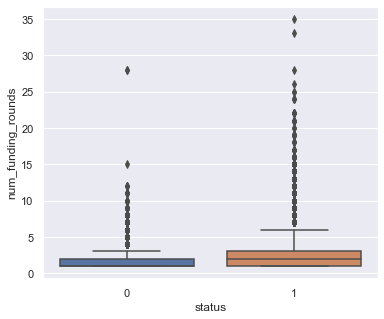

In [39]:
sns.set(rc={'figure.figsize':(6,5)})
sns.boxplot(x='status', y='num_funding_rounds', data = df)

<AxesSubplot:xlabel='status', ylabel='age'>

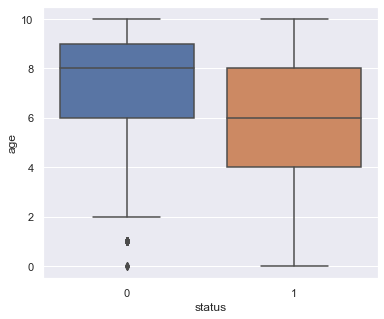

In [40]:
sns.set(rc={'figure.figsize':(6, 5)})
sns.boxplot(x='status', y='age', data = df)

<AxesSubplot:xlabel='status', ylabel='yrs_since_last_funding'>

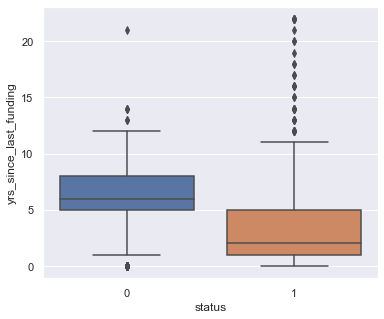

In [41]:
sns.set(rc={'figure.figsize':(6, 5)})
sns.boxplot(x='status', y='yrs_since_last_funding', data = df)

<AxesSubplot:xlabel='status', ylabel='last_funding_lag'>

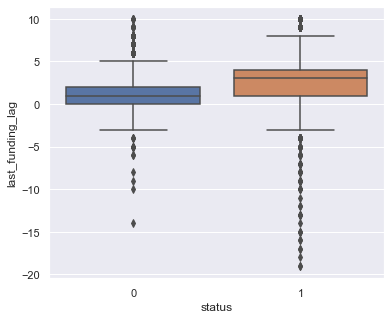

In [42]:
sns.set(rc={'figure.figsize':(6, 5)})
sns.boxplot(x='status', y='last_funding_lag', data = df)

There appear to be outliers, with respect to the financial variables. However, they are natural data points
that represent accurate values. They are therefore not excluded from the populations. 

The feature 'total_funding_usd' needs to be scaled and is done below:

### Scaling Total Funding USD

In [43]:
df['tf_usd_log'] = np.log(df['total_funding_usd'] + 0.0001)
#adding small value as log of zero is infinite

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df['tf_usd_scaled'] = ss.fit_transform(df['total_funding_usd'].values.reshape(-1,1))

from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
df['tf_usd_mm'] = mm.fit_transform(df['total_funding_usd'].values.reshape(-1,1))

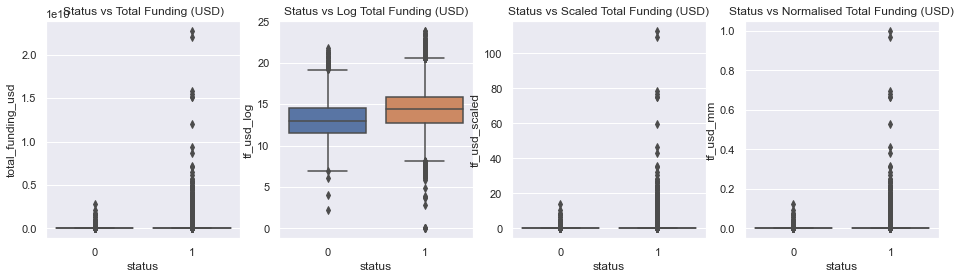

In [45]:
# Visualising Scaling Methods:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (16,4))

sns.boxplot(x='status',y='total_funding_usd',data=df, ax=axs[0])
axs[0].set_title("Status vs Total Funding (USD)")

sns.boxplot(x='status',y='tf_usd_log',data=df, ax=axs[1])
axs[1].set_title("Status vs Log Total Funding (USD)")

sns.boxplot(x='status',y='tf_usd_scaled',data=df, ax=axs[2])
axs[2].set_title("Status vs Scaled Total Funding (USD)")

sns.boxplot(x='status',y='tf_usd_mm',data=df, ax=axs[3])
axs[3].set_title("Status vs Normalised Total Funding (USD)")

plt.show()

We will be proceeding with the Log Transformation of Total Funding USD

Text(0.5, 1.0, 'Funding Distribution for Successful and Failed Companies')

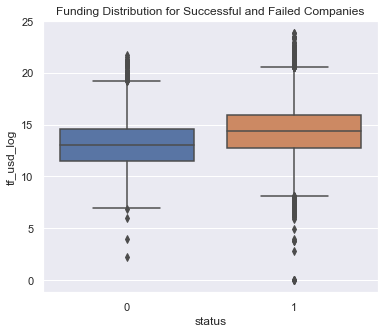

In [46]:
sns.set(rc={'figure.figsize':(6, 5)})
sns.boxplot(x='status', y='tf_usd_log', data = df)
plt.title('Funding Distribution for Successful and Failed Companies')

### Correlation Between Variables

In [47]:
df[['tf_usd_log','age','num_funding_rounds','yrs_since_last_funding','last_funding_lag','status']].corr()['status'].sort_values(ascending=False).head(10)

status                    1.000000
last_funding_lag          0.188391
tf_usd_log                0.164543
num_funding_rounds        0.098924
age                      -0.199719
yrs_since_last_funding   -0.353914
Name: status, dtype: float64

<AxesSubplot:title={'center':'Correlation Matrix of Continuous Variables'}>

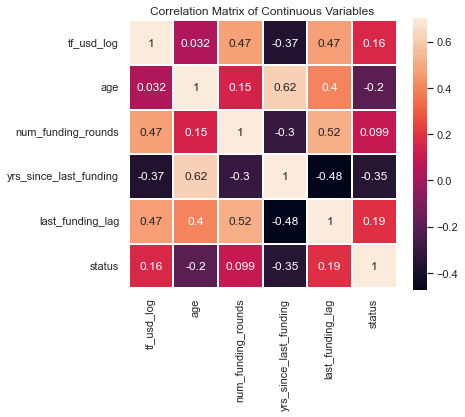

In [48]:
plt.title('Correlation Matrix of Continuous Variables')
sns.heatmap(df[['tf_usd_log','age','num_funding_rounds','yrs_since_last_funding','last_funding_lag','status']]
           .corr(),linewidths=0.25,vmax=0.7,square=True,cmap="rocket",linecolor='w',annot=True)

### One-Hot Encoding of Categorical Variables

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99434 entries, 386 to 2160247
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    99434 non-null  object 
 1   homepage_url            99434 non-null  object 
 2   region                  99434 non-null  object 
 3   status                  99434 non-null  int64  
 4   short_description       99434 non-null  object 
 5   num_funding_rounds      99434 non-null  float64
 6   total_funding_usd       99434 non-null  int64  
 7   employee_count          99434 non-null  object 
 8   age                     99434 non-null  int64  
 9   yrs_since_last_funding  99434 non-null  int64  
 10  last_funding_lag        99434 non-null  int64  
 11  social                  99434 non-null  object 
 12  sector                  99434 non-null  object 
 13  tf_usd_log              99434 non-null  float64
 14  tf_usd_scaled           99434 non-

In [50]:
df = pd.get_dummies(df, columns=["employee_count","social","sector","region"],
                   prefix=['emp','social','sector','region'])
df.head()

,name,homepage_url,status,short_description,num_funding_rounds,total_funding_usd,age,yrs_since_last_funding,last_funding_lag,tf_usd_log,tf_usd_scaled,tf_usd_mm,emp_LSE,emp_MSE,emp_SSE,social_Medium,social_None,social_Strong,social_Weak,sector_Communications Services,sector_Consumer Directory,sector_Consumer Staples,sector_Financial Services,sector_Health Care,sector_Industrials,sector_Real Estate,sector_Technology,region_Africa,region_Asia,region_Central America,region_Europe,region_Middle East,region_North America,region_Oceania,region_South America
386,Edgio,https://edg.io/company,1,Edgio provides edge-enabled solutions for busi...,1.0,130000000,0,16,-16,18.683045,0.529697,5.715115e-03,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
454,News Corp,http://www.newscorp.com,1,News Corp is a media and information services ...,3.0,512500000,9,0,9,20.054811,2.428483,2.253074e-02,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
505,Wolf - Band Radio,http://www.anywhere.fm,1,Ascolta ovunque dal Web.,1.0,15000,2,15,-13,9.615805,-0.115568,6.593924e-07,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
800,Ripl,https://www.ripl.com,1,Ripl is a software company with mobile and web...,8.0,8110000,10,5,5,15.908608,-0.075383,3.565352e-04,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
832,VoiceSell,http://www.voicesell.com,0,Mobile is becoming the dominant commerce custo...,1.0,4000000,4,3,1,15.201805,-0.095786,1.758496e-04,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [51]:
df.shape

(99434, 35)

### Checking Variance of Features 

In [52]:
print(df.var())

status                            9.366935e-02
num_funding_rounds                3.397117e+00
total_funding_usd                 4.058026e+16
age                               6.516009e+00
yrs_since_last_funding            7.067942e+00
last_funding_lag                  5.236166e+00
tf_usd_log                        5.593353e+00
tf_usd_scaled                     1.000010e+00
tf_usd_mm                         7.842925e-05
emp_LSE                           3.499708e-02
emp_MSE                           1.065695e-01
emp_SSE                           1.327581e-01
social_Medium                     1.496819e-01
social_None                       1.115157e-01
social_Strong                     2.457095e-01
social_Weak                       1.896776e-01
sector_Communications Services    4.455997e-02
sector_Consumer Directory         1.105259e-01
sector_Consumer Staples           1.217895e-01
sector_Financial Services         8.407043e-02
sector_Health Care                5.475947e-02
sector_Indust

/var/folders/k2/8mbjx2mx4jg3bkxxj6m1xbs40000gn/T/ipykernel_68552/1942798189.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df.var())


<function matplotlib.pyplot.show(close=None, block=None)>

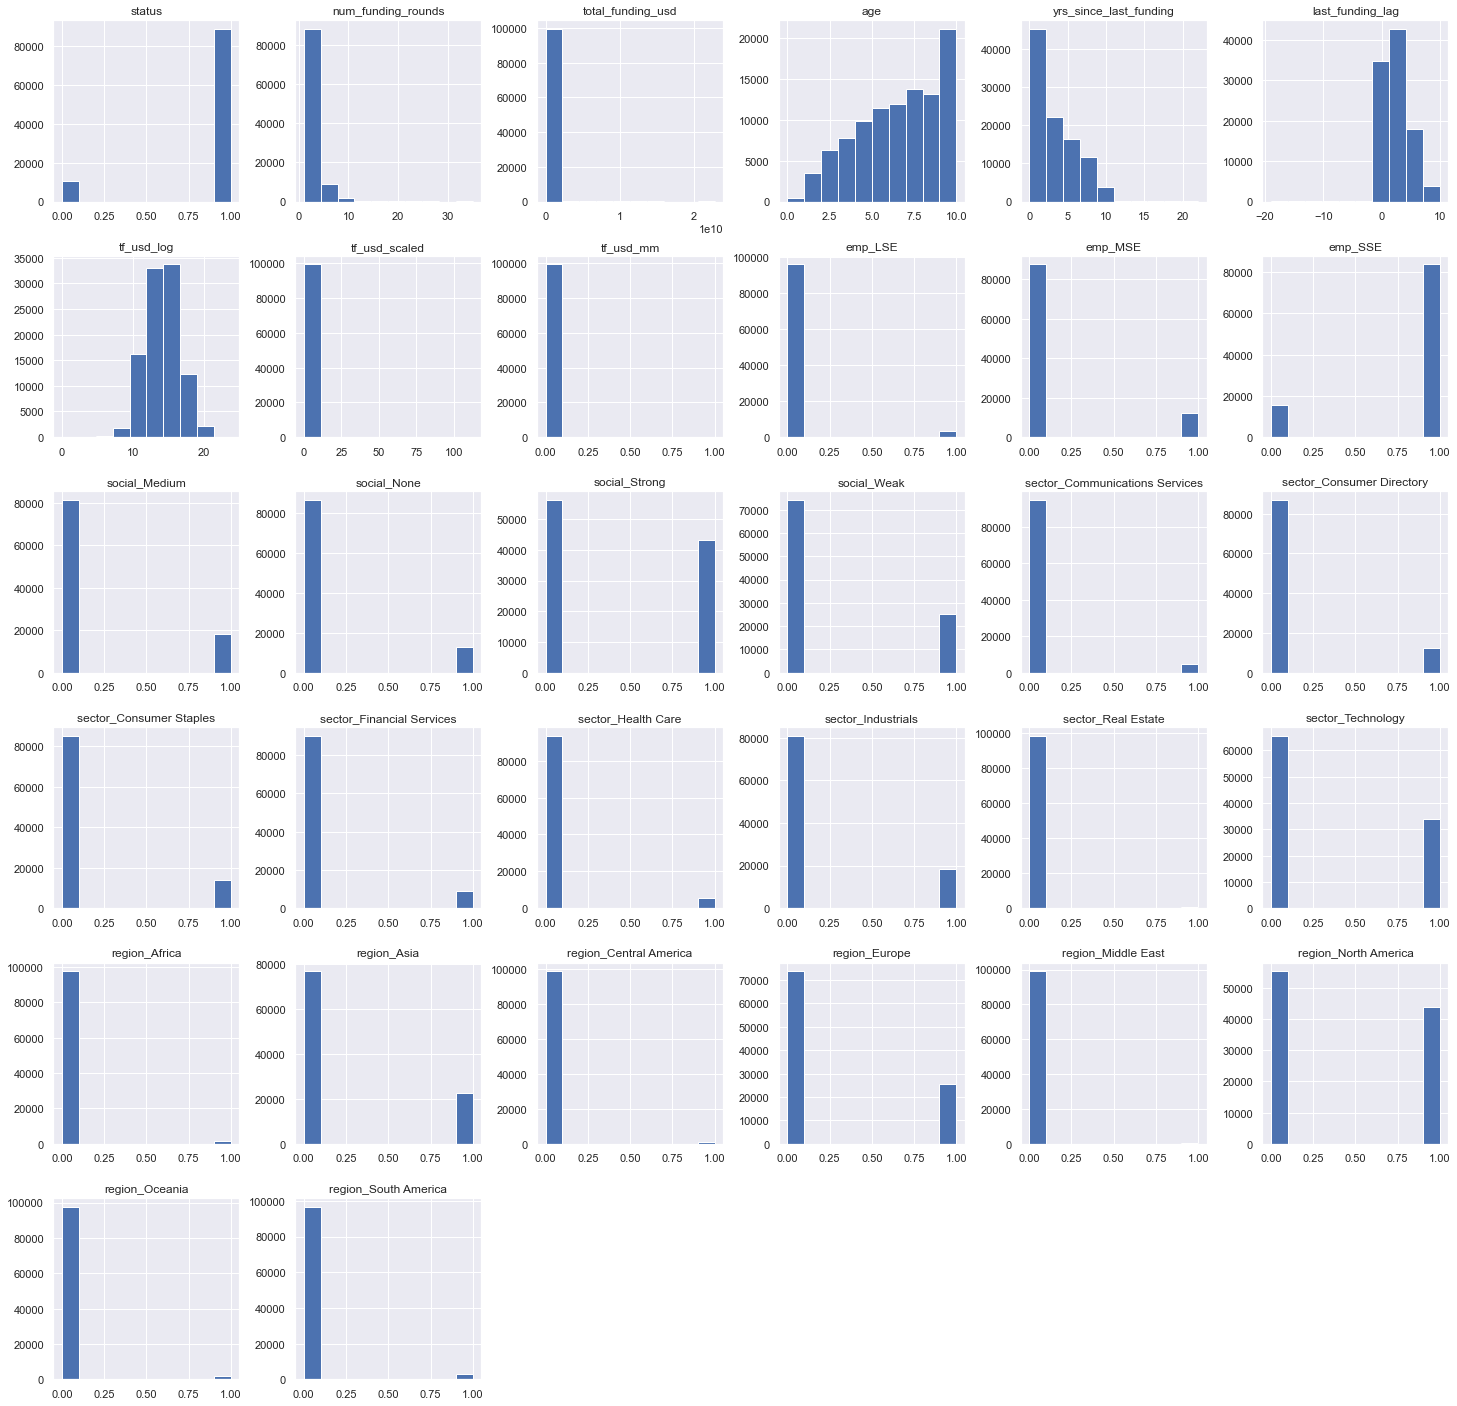

In [53]:
df.hist(figsize=(25,25))
plt.show

Features with near-zero variance to be dropped: 'Real Estate', 'Central America', 'Middle East', 'Oceania', 'Africa'

In [54]:
df = df.drop(df.loc[df['sector_Real Estate']=='1'].index)
df = df.drop(df.loc[df['region_Central America']=='1'].index)
df = df.drop(df.loc[df['region_Middle East']=='1'].index)
df = df.drop(df.loc[df['region_Oceania']=='1'].index)
df = df.drop(df.loc[df['region_Africa']=='1'].index)

In [55]:
df.shape

(99434, 35)

### Dropping the features not to be used in the final dataset

In [56]:
df = df.drop(['region_Oceania', 'region_Middle East', 'region_Central America', 
              'region_Africa', 'sector_Real Estate', 'tf_usd_mm', 'tf_usd_scaled',
             'total_funding_usd'], axis=1)


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99434 entries, 386 to 2160247
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            99434 non-null  object 
 1   homepage_url                    99434 non-null  object 
 2   status                          99434 non-null  int64  
 3   short_description               99434 non-null  object 
 4   num_funding_rounds              99434 non-null  float64
 5   age                             99434 non-null  int64  
 6   yrs_since_last_funding          99434 non-null  int64  
 7   last_funding_lag                99434 non-null  int64  
 8   tf_usd_log                      99434 non-null  float64
 9   emp_LSE                         99434 non-null  uint8  
 10  emp_MSE                         99434 non-null  uint8  
 11  emp_SSE                         99434 non-null  uint8  
 12  social_Medium               

In [58]:
df.to_csv('cleaned.csv')

### Deriving Descriptive Variable Statistics

In [122]:
df.groupby(['sector_Health Care', 'status']).size()

sector_Health Care  status
0                   0          9950
                    1         83703
1                   0           452
                    1          5329
dtype: int64

In [116]:
30190/33842

0.8920867561018853

In [117]:
df.status.value_counts()

1    89032
0    10402
Name: status, dtype: int64

In [118]:
89032/99434

0.8953878954884648